<a href="https://colab.research.google.com/github/wolandmargarita/healthy-bees/blob/main/bee_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This is a multi-label classification problem where I am training a convolutional neural network to recognize whether
or not a bee in a 300x150x3 is (1) carrying pollen, (2) flapping its wings for cooling the hive, (3) infected by
varroa mites, or (4) is a wasp.

1st Iteration:

-Updated the learning rate from 0.0001 to 0.0005

-Check if labels are one-hot encoded - NOT; one-hot encoded is for multi-class classification problems where at least
one of the labels has a 1; USE BINARY CROSS ENTROPY FOR LOSS; USE SIGMOID FOR THE OUTPUT LAYER

-Deeper CNN with successive 32 and 64 filter layers

2nd Iteration:

- Added Dropout (50%) and 128 filter layer

'''
import tensorflow_datasets as tfds
import tensorflow as tfds
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
local_data_dir = '~/ML/datasets'

import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
dataset, ds_info = tfds.load('bee_dataset', split='train', as_supervised=True, with_info=True, data_dir=local_data_dir)

In [ ]:
batch_size = 10  # you can adjust this value as needed

# Total samples
total_samples = ds_info.splits['train'].num_examples

# Calculate the number of samples for 80%
num_train_samples = int(ds_info.splits['train'].num_examples * 0.8)

# Setup the data input pipeline
# ds_train = dataset.take(num_train_samples).cache().batch(batch_size).repeat()
# ds_test = dataset.skip(num_train_samples).cache().batch(batch_size).repeat()

# Corrected data input pipeline
ds_train = dataset.take(num_train_samples).cache().repeat().batch(batch_size)
ds_test = dataset.skip(num_train_samples).cache().repeat().batch(batch_size)

# Function to extract image and label arrays from the dataset
def extract_images_and_labels(ds, total_samples):
    i = 0
    images = []
    labels = []

    for batch_img, batch_labels in tfds.as_numpy(ds.take((total_samples + batch_size - 1) // batch_size)):
        current_batch_size = len(batch_img)
        images.extend(batch_img)
        labels.extend([{key: batch_labels[key][i] for key in batch_labels} for i in range(current_batch_size)])

    return images, labels

train_X, train_Y = extract_images_and_labels(ds_train, num_train_samples)
test_x, test_y = extract_images_and_labels(ds_test, total_samples - num_train_samples)

train_X = np.array(train_X)
train_Y = np.array(train_Y)
test_x = np.array(test_x)
test_y = np.array(test_y)

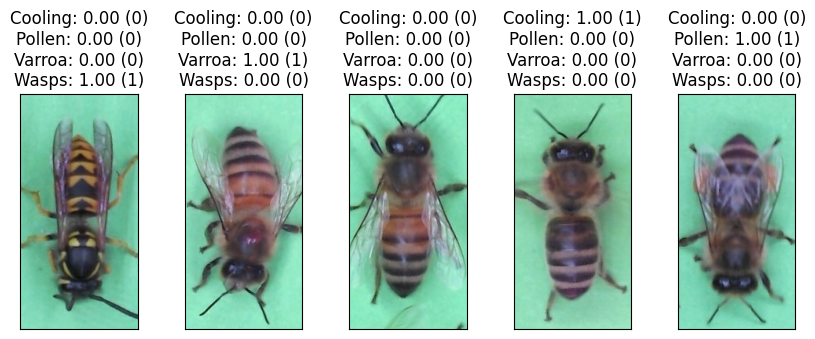

In [ ]:
import matplotlib.pyplot as plt

def display_images(images, labels, num_to_display=5):
    """Display the first 'num_to_display' images from the 'images' list."""
    fig, axes = plt.subplots(1, num_to_display, figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.4, wspace=0.4))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].astype('uint8'))

        label_text = (f"Cooling: {labels[i]['cooling_output']:.2f} ({int(labels[i]['cooling_output'] > 0.5)})\n"
                      f"Pollen: {labels[i]['pollen_output']:.2f} ({int(labels[i]['pollen_output'] > 0.5)})\n"
                      f"Varroa: {labels[i]['varroa_output']:.2f} ({int(labels[i]['varroa_output'] > 0.5)})\n"
                      f"Wasps: {labels[i]['wasps_output']:.2f} ({int(labels[i]['wasps_output'] > 0.5)})")
        ax.set_title(label_text)

    plt.show()

# Call the function to display the first 5 images from train_X
display_images(train_X, train_Y)

In [ ]:
percent_cooling = np.mean([1 if entry['cooling_output'] == 1.0 else 0 for entry in train_Y]) * 100
percent_pollen = np.mean([1 if entry['pollen_output'] == 1.0 else 0 for entry in train_Y]) * 100
percent_varroa = np.mean([1 if entry['varroa_output'] == 1.0 else 0 for entry in train_Y]) * 100
percent_wasps = np.mean([1 if entry['wasps_output'] == 1.0 else 0 for entry in train_Y]) * 100

print(f"Cooling Output: {percent_cooling:.2f}%")
print(f"Pollen Output: {percent_pollen:.2f}%")
print(f"Varroa Output: {percent_varroa:.2f}%")
print(f"Wasps Output: {percent_wasps:.2f}%")


Cooling Output: 15.42%
Pollen Output: 13.60%
Varroa Output: 16.73%
Wasps Output: 12.58%


In [ ]:
# Convert data for model
# new_shape = (64,64)
# train_X_resized = tf.image.resize(train_X_tensor, new_shape)

# Convert sets back to tensors from np arrays
train_X_tensor = tf.convert_to_tensor(train_X, dtype=tf.float32) / 255.0

# Convert list of dictionaries to list of lists
data_matrix = [[entry['cooling_output'], entry['pollen_output'], entry['varroa_output'], entry['wasps_output']] for entry in train_Y]

# Convert list of lists to a numpy array
data_np = np.array(data_matrix)

# Convert numpy array to a TensorFlow tensor
train_Y_tensor = tf.convert_to_tensor(data_np, dtype=tf.float32)


In [ ]:
from tensorflow.keras.applications import ResNet50

# Set up the model with Transfer Learning
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(300, 150, 3))

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (2, 2), activation='relu')) # Added convolution layer
model.add(Dropout(0.50))
model.add(Conv2D(128, (3, 3), activation='relu')) # Increased filter count
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(256, activation='relu')) # Increased neuron count
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False  # Freeze the layers of the pre-trained model

optimizer = Adam(learning_rate=0.0005)  # Set your desired learning rate here
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

train_gen = datagen.flow(train_X_tensor, train_Y_tensor, batch_size=4)


In [ ]:
# Train
history = model.fit(train_gen, epochs=20, batch_size=batch_size)

In [ ]:
# Display results
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

def is_one_hot_encoded(matrix):
    # If it's a TensorFlow tensor, convert it to a numpy array
    if hasattr(matrix, 'numpy'):
        matrix = matrix.numpy()
    else:
        matrix = np.array(matrix)

    # Each row should sum to 1 (since one-hot vectors have one '1' and the rest are '0's)
    row_sums = np.sum(matrix, axis=1)
    unique_sums = np.unique(row_sums)

    # If there's only one unique sum and it's 1, then it's one-hot encoded
    return len(unique_sums) == 1 and unique_sums[0] == 1

# Example
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]
print(is_one_hot_encoded(labels))  # True
